In [177]:
import os
import time
import string
import math

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing, neighbors, metrics, pipeline, \
    impute, compose, model_selection
%matplotlib inline

In [16]:
data_dir = os.path.join("datasets", "titanic")
train_path = os.path.join(data_dir, "titanic_train.csv")
test_path = os.path.join(data_dir, "titanic_test.csv")

train = pd.read_csv(train_path)
test = pd.read_csv(test_path)

In [24]:
def camel_to_snake(colname):
    """e.g. CamelCaseColumn --> camel_case_column"""
    accumulator = []
    for i, char in enumerate(colname):
        is_cap = char in string.ascii_uppercase
        if is_cap:
            lower_char = char.lower()
            if i != 0:
                accumulator.append("_")
            accumulator.append(lower_char)
        else:
            accumulator.append(char)
    snake_case_colname = ''.join(accumulator)
    return snake_case_colname

In [30]:
train.columns = [camel_to_snake(col) for col in train.columns]
test.columns = [camel_to_snake(col) for col in test.columns]

In [31]:
train.head()

,passenger_id,survived,pclass,name,sex,age,sib_sp,parch,ticket,fare,cabin,embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [33]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   passenger_id  891 non-null    int64  
 1   survived      891 non-null    int64  
 2   pclass        891 non-null    int64  
 3   name          891 non-null    object 
 4   sex           891 non-null    object 
 5   age           714 non-null    float64
 6   sib_sp        891 non-null    int64  
 7   parch         891 non-null    int64  
 8   ticket        891 non-null    object 
 9   fare          891 non-null    float64
 10  cabin         204 non-null    object 
 11  embarked      889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


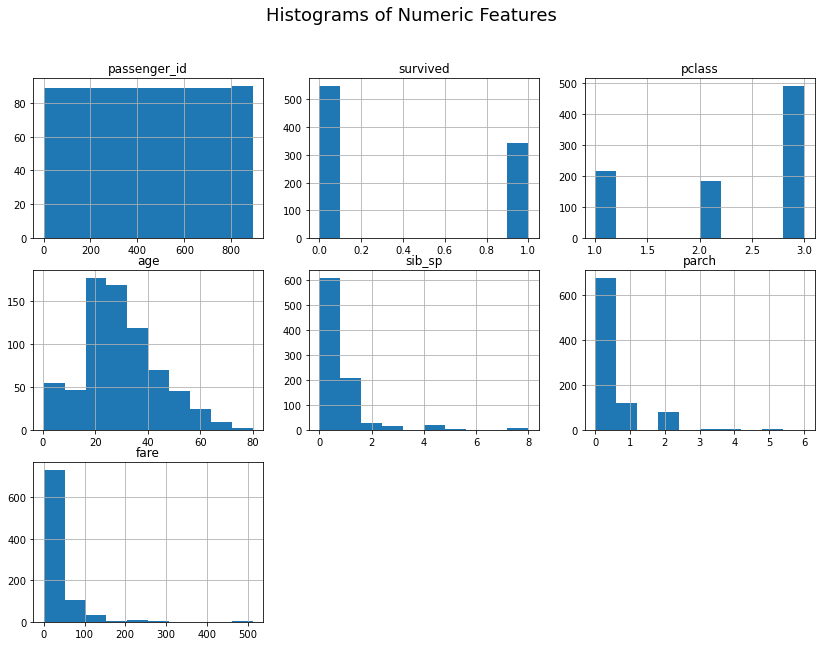

In [97]:
numeric_cols = train.select_dtypes(include=[np.int64, np.float64]).columns

ncols = 3
nrows = math.floor(len(numeric_cols) / 3) + (1 * len(numeric_cols) % 3)
fig, axs = plt.subplots(nrows, ncols, figsize=(14, 10))
fig.suptitle('Histograms of Numeric Features', size=18)

for i, col in enumerate(numeric_cols):
    ax = axs.flatten()[i]
    train[col].hist(ax=ax)
    ax.set_title(col)
    
for i, ax in enumerate(axs.flatten()):
    if i >= len(numeric_cols):
        ax.axis("off")

plt.show();

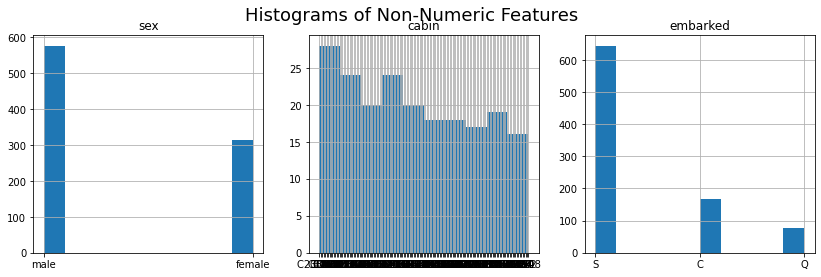

In [96]:
manually_exclude = ["name", "ticket"]  # Uq identifiers don't need a hist
non_numeric_cols = train.select_dtypes(exclude=[np.int64, np.float64]).columns
non_numeric_cols = [c for c in non_numeric_cols if c not in manually_exclude]

ncols = 3
nrows = math.floor(len(non_numeric_cols) / 3) + (1 * len(non_numeric_cols) % 3)
fig, axs = plt.subplots(nrows, ncols, figsize=(14, 4))
fig.suptitle('Histograms of Non-Numeric Features', size=18)

for i, col in enumerate(non_numeric_cols):
    ax = axs.flatten()[i]
    train[col].hist(ax=ax)
    ax.set_title(col)
    
for i, ax in enumerate(axs.flatten()):
    if i >= len(non_numeric_cols):
        ax.axis("off")
        
plt.show();

In [143]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   passenger_id  891 non-null    int64  
 1   survived      891 non-null    int64  
 2   pclass        891 non-null    int64  
 3   name          891 non-null    object 
 4   sex           891 non-null    object 
 5   age           714 non-null    float64
 6   sib_sp        891 non-null    int64  
 7   parch         891 non-null    int64  
 8   ticket        891 non-null    object 
 9   fare          891 non-null    float64
 10  cabin         204 non-null    object 
 11  embarked      889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [175]:
target = "survived"
too_many_nans = ["cabin"]
uq_ids = ["passenger_id", "ticket", "name"]

onehot = preprocessing.OneHotEncoder()
imputer = impute.SimpleImputer(strategy="median")
scaler = preprocessing.StandardScaler()

train_ = (train.drop(too_many_nans + uq_ids, axis=1)
          .dropna(subset=["age", "embarked"]))

num_cols = ["age", "fare"]
cat_cols = ["pclass", "sex", "sib_sp", "parch", "embarked"]

col_trafo = compose.ColumnTransformer([
    ("num", imputer, num_cols),
    ("cat", onehot, cat_cols)
])

transformer_pipe = pipeline.Pipeline([
    ("col_trafo", col_trafo),
    ("scaler", scaler),
])

X_train = transformer_pipe.fit_transform(train_.drop(target, axis=1))
y_train = train_[target]

In [200]:
knn_clf = neighbors.KNeighborsClassifier(algorithm="auto")
param_grid = [
    {
        "n_neighbors": np.linspace(2, 100, num=99).astype(int),
        "weights": ["uniform", "distance"],
    }
]
cv = 3

start = time.time()
grid_search = model_selection.GridSearchCV(knn_clf, param_grid, cv=cv,
                                           verbose=5, n_jobs=8, refit=True)
grid_search.fit(X_train, y_train)
end = time.time()
print(f"Grid Seach took {round(end-start, 2)} seconds")
print(f"Best model accuracy is: {round(grid_search.best_score_*100, 2)}%")

Fitting 3 folds for each of 198 candidates, totalling 594 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 176 tasks      | elapsed:    0.3s


Grid Seach took 0.84 seconds
Best model accuracy is: 78.24%


[Parallel(n_jobs=8)]: Done 562 tasks      | elapsed:    0.8s
[Parallel(n_jobs=8)]: Done 594 out of 594 | elapsed:    0.8s finished
